# Web Scraping for Indeed.com & Predicting Salaries

In this project, we will practice two major skills: collecting data by scraping a website and then building a binary predictor with Logistic Regression.

We are going to collect salary information on data science jobs in a variety of markets. Then using the location, title and summary of the job we will attempt to predict the salary of the job. For job posting sites, this would be extraordinarily useful. While most listings DO NOT come with salary information (as you will see in this exercise), being to able extrapolate or predict the expected salaries from other listings can help guide negotiations.

Normally, we could use regression for this task; however, we will convert this problem into classification and use Logistic Regression.

- Question: Why would we want this to be a classification problem?
- Answer: While more precision may be better, there is a fair amount of natural variance in job salaries - predicting a range be may be useful.

Therefore, the first part of the assignment will be focused on scraping Indeed.com. In the second, we'll focus on using listings with salary information to build a model and predict additional salaries.

### Scraping job listings from Indeed.com

We will be scraping job listings from Indeed.com using BeautifulSoup. Luckily, Indeed.com is a simple text page where we can easily find relevant entries.

First, look at the source of an Indeed.com page: (http://www.indeed.com/jobs?q=data+scientist+%2420%2C000&l=New+York&start=10")

Notice, each job listing is underneath a `div` tag with a class name of `result`. We can use BeautifulSoup to extract those. 

#### Setup a request (using `requests`) to the URL below. Use BeautifulSoup to parse the page and extract all results (HINT: Look for div tags with class name result)

In [1]:
#URL = "http://www.indeed.com/jobs?q=data+scientist+%2420%2C000&l=New+York&start=10"  # This was part of the starter code.
URL = "http://www.indeed.com/jobs?q=data+scientist+%2420%2C000&l=Los+Angeles&limit=50"  # Better

In [2]:
import requests
# import bs4
from bs4 import BeautifulSoup
import pandas as pd

In [3]:
r = requests.get(URL) # Get the HTML for the given URL
bs = BeautifulSoup(r.text,'lxml')  # parse the HTML and load it into a BeautifulSoup object

Let's look at one result more closely. A single `result` looks like

```
<div class=" row result" data-jk="2480d203f7e97210" data-tn-component="organicJob" id="p_2480d203f7e97210" itemscope="" itemtype="http://schema.org/JobPosting">
<h2 class="jobtitle" id="jl_2480d203f7e97210">
<a class="turnstileLink" data-tn-element="jobTitle" onmousedown="return rclk(this,jobmap[0],1);" rel="nofollow" target="_blank" title="AVP/Quantitative Analyst">AVP/Quantitative Analyst</a>
</h2>
<span class="company" itemprop="hiringOrganization" itemtype="http://schema.org/Organization">
<span itemprop="name">
<a href="/cmp/Alliancebernstein?from=SERP&amp;campaignid=serp-linkcompanyname&amp;fromjk=2480d203f7e97210&amp;jcid=b374f2a780e04789" target="_blank">
    AllianceBernstein</a></span>
</span>
<tr>
<td class="snip">
<nobr>$117,500 - $127,500 a year</nobr>
<div>
<span class="summary" itemprop="description">
C onduct quantitative and statistical research as well as portfolio management for various investment portfolios. Collaborate with Quantitative Analysts and</span>
</div>
</div>
</td>
</tr>
</table>
</div>
```

While this has some more verbose elements removed, we can see that there is some structure to the above:
- The salary is available in a `nobr` element inside of a `td` element with `class='snip`.
- The title of a job is in a link with class set to `jobtitle` and a `data-tn-element="jobTitle`.  
- The location is set in a `span` with `class='location'`. 
- The company is set in a `span` with `class='company'`. 

### Write 4 functions to extract each item: location, company, job, and salary.

example: 
```python
def extract_location_from_result(result):
    return result.find ...
```


- Make sure these functions are robust and can handle cases where the data/field may not be available.
- Test the functions on the results above

In [4]:
# Create a dictionary object that will hold our data as we extract it from the HTML.
dictJobListing = {'ID':[],
                 'Title': [],
                 'Company':[],
                 'Salary':[],
                 'Location':[],
                 'Description':[]}

def LoadHTMLDict(tagList,dictionary,key):
    # tagList is a list of tag objects whose text attribute we want to collect and load into a dictionary.
    # dictionary is a dict object where the data will be loaded.
    # key is the name of the key in the dictionary where we will add the text from the TagList
    # RETURN: the number of items that were added.
    count = 0
    for tag in tagList:
        count += 1
        dictionary[key].append(tag.text.strip())
    return count

In [5]:
# Load the Job Title
JobTitletag = bs.select('a[data-tn-element="jobTitle"]')
results = LoadHTMLDict(JobTitletag,dictJobListing,'Title')

# Load the Company name
companyTag = bs.select('span.company')
results = LoadHTMLDict(companyTag,dictJobListing,'Company')

# Load the Location
locationTag = bs.select('span.location')
results = LoadHTMLDict(locationTag,dictJobListing,'Location')

# Load the Description
descriptionTag = bs.select('span.summary')
results = LoadHTMLDict(descriptionTag,dictJobListing,'Description')

# Load the Salary
salaryTag = bs.select('td.snip nobr')
results = LoadHTMLDict(salaryTag,dictJobListing,'Salary')

# for each Salary found, we need to get the corresponding ID (data-jk) and then place the salary value
# in the corresponding dictionary list, at the index that corresponds to the matching ID.
# for salary in salaryList.
# TDW - ABORTED THIS APPROACH after data file was provided.

## LOAD ID
# Load the data-jk attribute for each data row - this is a unique identifier (theory) for each job listing.
IDtags = bs.select("div")
counter = 0
for ID in IDtags:
    tempDict = ID.attrs
    if tempDict.has_key('data-jk'):
        dictJobListing['ID'].append(tempDict['data-jk'])

# # FOR DEBUG & INFO
# print 'Load of Los Angeles job listings'
# print len(dictJobListing['ID'])
# print len(dictJobListing['Title'])
# print len(dictJobListing['Company'])
# print len(dictJobListing['Location'])
# print len(dictJobListing['Description'])
# print len(dictJobListing['Salary'])

Now, to scale up our scraping, we need to accumulate more results. We can do this by examining the URL above.

- "http://www.indeed.com/jobs?q=data+scientist+%2420%2C000&l=New+York&start=10"

There are two query parameters here we can alter to collect more results, the `l=New+York` and the `start=10`. The first controls the location of the results (so we can try a different city). The second controls where in the results to start and gives 10 results (thus, we can keep incrementing by 10 to go further in the list).

#### Complete the following code to collect results from multiple cities and starting points. 
- Enter your city below to add it to the search
- Remember to convert your salary to U.S. Dollars to match the other cities if the currency is different

In [6]:
YOUR_CITY = 'Portland'

In [7]:
# url_template = "http://www.indeed.com/jobs?q=data+scientist+%2420%2C000&l={}&start={}" # This was part of starter code
baseurl_template = "http://www.indeed.com/jobs?q=data+scientist+%2420%2C000" # Better  &l={CITY}&limit={NUM RESULTS}
max_results_per_city = 100

results = []

# Cycle through each city in the list below, and scrape job listings.
for city in set(['New+York', 'Chicago', 'San+Francisco', 'Austin', YOUR_CITY]):
    # Grab the results from the request (as above)
    cityURL = baseurl_template + '&l=' + city + '&limit=' + str(max_results_per_city)
    r = requests.get(cityURL) # Get the HTML for the given URL
    # Append to the full set of results
    results.append(r.text)

#### Use the functions you wrote above to parse out the 4 fields - location, title, company and salary. Create a dataframe from the results with those 4 columns.

In [8]:
for r in results:
    # Parse the HTML
    bs = BeautifulSoup(r,'lxml')
    
    # Process each set of HTML    
    # Load the Job Title
    JobTitletag = bs.select('a[data-tn-element="jobTitle"]')
    results = LoadHTMLDict(JobTitletag,dictJobListing,'Title')

    # Load the Company name
    companyTag = bs.select('span.company')
    results = LoadHTMLDict(companyTag,dictJobListing,'Company')

    # Load the Location
    locationTag = bs.select('span.location')
    results = LoadHTMLDict(locationTag,dictJobListing,'Location')

    # Load the Salary
    salaryTag = bs.select('td.snip nobr')
    results = LoadHTMLDict(salaryTag,dictJobListing,'Salary')

    # Load the Description
    descriptionTag = bs.select('span.summary')
    results = LoadHTMLDict(descriptionTag,dictJobListing,'Description')
    
## LOAD ID
# Load the data-jk attribute for each data row - this is a unique identifier (theory) for each job listing.
# This could be useful in the future.
IDtags = bs.select("div")

for ID in IDtags:
    tempDict = ID.attrs
    if tempDict.has_key('data-jk'):
        dictJobListing['ID'].append(tempDict['data-jk'])

# # FOR DEBUG & INFO
# print 'Load of job listings - Row counts'
# print 'ID: ',len(dictJobListing['ID'])
# print 'Title: ',len(dictJobListing['Title'])
# print 'Company: ',len(dictJobListing['Company'])
# print 'Location: ',len(dictJobListing['Location'])
# print 'Description: ',len(dictJobListing['Description'])
# print 'Salary: ',len(dictJobListing['Salary'])

# dfJobListings = pd.DataFrame(dictJobListing['Title','Company','Location','Description'],columns=['Title','Company','Location','Description'])
# print dfJobListings.shape
# dfJobListings.info()

# A data file of job listings was provided to us.  The remainder of the code will clean, transform, and use that data for logistic regression modeling.

In [9]:
# Load the data from the data file provided by the instructors.
dataPath = '../assets/'
dataFile = 'indeed-scraped-job-postings.csv'
dfJobListing = pd.read_csv(dataPath + dataFile)

# Print informative information about the recently loaded data.
print 'SHAPE: ',str(dfJobListing.shape)
print 'INFO:'
dfJobListing.info()
print 'DATA TYPES:  '
dfJobListing.dtypes
print 'Describe:  '
dfJobListing.describe()

SHAPE:  (4791, 6)
INFO:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4791 entries, 0 to 4790
Data columns (total 6 columns):
city             4791 non-null object
company          4791 non-null object
salary           4791 non-null object
summary          4791 non-null object
title            4791 non-null object
parsed_salary    4789 non-null float64
dtypes: float64(1), object(5)
memory usage: 224.6+ KB
DATA TYPES:  
Describe:  


,parsed_salary
count,4789.000000
mean,66183.785550
std,64348.141986
min,2333.000000
25%,5950.000000
50%,74550.000000
75%,130000.000000
max,300000.000000


Lastly, we need to clean up salary data. 
1. Some of the salaries are not yearly but hourly, these will be useful to us for now
2. The salaries are given as text and usually with ranges.

#### Filter out the salaries that are not yearly (filter those that refer to hour)

In [10]:
# Transform the parsed_salary column so they are all in the same units (salary per year)
# ASSUMPTION:  Any parsed_salary value that is less than $20,000 will be assumed to be a monthly salary.
dfJobListing['parsed_salary'] = dfJobListing['parsed_salary'].apply(lambda x: x*12 if (x < 20000) else x)
dfJobListing.describe()

dfJobListing['city'] = dfJobListing['city'].apply(lambda x: x.replace('+',' '))
dfJobListing.head(5)
dfJobListing.tail(5)

,city,company,salary,summary,title,parsed_salary
4786,Chicago,Workbridge Associates,"$110,000 - $150,000 a year",This agile team will create and develop new so...,Senior Java Computer Scientist,130000.0
4787,Chicago,Clinical Management Consultants,"$71,384 - $93,274 a year",Manager Health Information Management Data Ana...,Manager Health Information Management Data Ana...,82329.0
4788,Chicago,Workbridge Associates,"$170,000 a year","Big Data with Hadoop, Hive, Impala. Mid, Senio...",Director of Data Analytics,170000.0
4789,Chicago,Clinical Management Consultants,"$71,384 - $93,274 a year",Manager Health Information Management Data Ana...,Manager Health Information Management Data Ana...,82329.0
4790,Chicago,Workbridge Associates,"$170,000 a year","Big Data with Hadoop, Hive, Impala. Mid, Senio...",Director of Data Analytics,170000.0


In [11]:
def generateSalaryRange(salary):
    if salary <= 100000:
        return 'A'
    elif (salary > 100000) and (salary <= 200000):
        return 'B'
    elif (salary > 200000) and (salary <= 300000):
        return 'C'
    else:
        return 'X'
    
# Create a new column which will contain a code indicating the range that a salary falls in to.
dfJobListing['salary_range'] = dfJobListing['parsed_salary'].apply(generateSalaryRange)
dfJobListing[dfJobListing['salary_range'] == 'X' ]

# Found 2 records which had daily rates, so the parsed_salary was incorrect.  Fix these.
dfJobListing.ix[438,'parsed_salary'] = 775 * 52 * 5 # Mean daily rate * 52 weeks * 5 days/week
dfJobListing.ix[438,'salary_range'] = 'C'
dfJobListing.ix[456,'parsed_salary'] = 775 * 52 * 5 # Mean daily rate * 52 weeks * 5 days/week
dfJobListing.ix[456,'salary_range'] = 'C'
dfJobListing[dfJobListing['salary_range'] == 'X' ]

,city,company,salary,summary,title,parsed_salary,salary_range


In [12]:
# Create a position_level column which will contain categorized data for the Title.
def generatePositionLevel(title):
    title = title.lower()
    if (title.find('manager',0,len(title)) >= 0) or (title.find('management',0,len(title)) >= 0):
        return 'manager'
    elif (title.find('senior',0,len(title)) >= 0) or (title.find('vp',0,len(title)) >= 0) or (title.find('director',0,len(title)) >= 0):
        return 'senior'
    return 'other'
    
dfJobListing['position_level'] = dfJobListing['title'].apply(generatePositionLevel)
dfJobListing.head()

,city,company,salary,summary,title,parsed_salary,salary_range,position_level
0,San Francisco,MarkMonitor,"$180,000 a year","Data skills (SQL, Hive, Pig). Applying machine...",Data Scientist,180000.0,B,other
1,San Francisco,Workbridge Associates,"$130,000 - $180,000 a year",3+ years of industry experience in a data scie...,Senior Data Scientist,155000.0,B,senior
2,San Francisco,Mines.io,"$80,000 - $120,000 a year",We are looking for a data scientist/developer ...,Full-Stack Data Scientist,100000.0,A,other
3,San Francisco,Workbridge Associates,"$150,000 - $180,000 a year",In this position you will share programming an...,Data Scientist,165000.0,B,other
4,San Francisco,Smith Hanley Associates,"$140,000 a year","This person will recruit, build and lead a tea...",Data Scientist,140000.0,B,other


In [13]:
# Create skill columns which will contain binary data for the Skills.
def generateSkills(jobDescription, skill):
    jobDescription = jobDescription.lower()
    skill = skill.lower()
    if jobDescription.find(skill) >= 0:
        return 1
    return 0

# We limited the skills columns to python, sql and machine learning
dfJobListing['skill_python'] = [generateSkills(x,'python') for x in dfJobListing.summary]
dfJobListing['skill_sql'] = [generateSkills(x,'sql') for x in dfJobListing.summary]
dfJobListing['skill_machine_learning'] = [generateSkills(x,'machine learning') for x in dfJobListing.summary]
dfJobListing.head()

,city,company,salary,summary,title,parsed_salary,salary_range,position_level,skill_python,skill_sql,skill_machine_learning
0,San Francisco,MarkMonitor,"$180,000 a year","Data skills (SQL, Hive, Pig). Applying machine...",Data Scientist,180000.0,B,other,0,1,1
1,San Francisco,Workbridge Associates,"$130,000 - $180,000 a year",3+ years of industry experience in a data scie...,Senior Data Scientist,155000.0,B,senior,1,0,0
2,San Francisco,Mines.io,"$80,000 - $120,000 a year",We are looking for a data scientist/developer ...,Full-Stack Data Scientist,100000.0,A,other,0,0,0
3,San Francisco,Workbridge Associates,"$150,000 - $180,000 a year",In this position you will share programming an...,Data Scientist,165000.0,B,other,0,0,0
4,San Francisco,Smith Hanley Associates,"$140,000 a year","This person will recruit, build and lead a tea...",Data Scientist,140000.0,B,other,0,0,0


In [14]:
# Add a column 'above_median' which notes whether it is above or equal to (1), or below (0), the median salary.
medianSalary = dfJobListing.parsed_salary.median()

dfJobListing['above_median'] = dfJobListing['parsed_salary'].apply(lambda x: 1 if (x >= medianSalary) else 0)
dfJobListing.tail()

,city,company,salary,summary,title,parsed_salary,salary_range,position_level,skill_python,skill_sql,skill_machine_learning,above_median
4786,Chicago,Workbridge Associates,"$110,000 - $150,000 a year",This agile team will create and develop new so...,Senior Java Computer Scientist,130000.0,B,senior,0,0,0,1
4787,Chicago,Clinical Management Consultants,"$71,384 - $93,274 a year",Manager Health Information Management Data Ana...,Manager Health Information Management Data Ana...,82329.0,A,manager,0,0,0,0
4788,Chicago,Workbridge Associates,"$170,000 a year","Big Data with Hadoop, Hive, Impala. Mid, Senio...",Director of Data Analytics,170000.0,B,senior,1,0,0,1
4789,Chicago,Clinical Management Consultants,"$71,384 - $93,274 a year",Manager Health Information Management Data Ana...,Manager Health Information Management Data Ana...,82329.0,A,manager,0,0,0,0
4790,Chicago,Workbridge Associates,"$170,000 a year","Big Data with Hadoop, Hive, Impala. Mid, Senio...",Director of Data Analytics,170000.0,B,senior,1,0,0,1


#### Write a function that takes a salary string and converts it to a number, averaging a salary range if necessary

In [15]:
# This was already done in the dataset that was provided.

### Save your results as a CSV

In [16]:
dfJobListing.to_csv('indeedClean.csv')

## Predicting salaries using Logistic Regression

#### Load in the the data of scraped salaries

In [17]:
# Already done :)

#### We want to predict a binary variable - whether the salary was low or high. Compute the median salary and create a new binary variable that is true when the salary is high (above the median)

In [18]:
# Already done :)

#### Thought experiment: What is the baseline accuracy for this model?

#### Create a Logistic Regression model to predict High/Low salary using statsmodel. Start by ONLY using the location as a feature. Display the coefficients and write a short summary of what they mean.

In [19]:
from sklearn.linear_model import LogisticRegression
import patsy
from sklearn.cross_validation import train_test_split
from sklearn import datasets, neighbors, metrics
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix
from sklearn import grid_search, cross_validation
import statsmodels.api as sm

In [20]:
# Create a data dictionary that will collect analytical information about each model.
# KEYS:  runID, regression, featureCols, ycol, measure, result, notes
modelRunStats = {'runID':[],
                'regression':[],
                'featureCols':[],
                'ycol': [],
                'measure':[],
                'result':[],
                'notes':[]}

def logModelRun(ID,regression,featureCols,ycol,measure,result,notes=''):
    modelRunStats['runID'].append(ID)
    modelRunStats['regression'].append(regression)
    modelRunStats['featureCols'].append(featureCols)
    modelRunStats['ycol'].append(ycol)
    modelRunStats['measure'].append(measure)
    modelRunStats['result'].append(result)
    modelRunStats['notes'].append(notes)
    return len(modelRunStats['runID'])

In [21]:
# Prepare our training and test data.
featuresList = ['city']
yCol = 'above_median'

# create the feature matrix
Xmatrix = patsy.dmatrix('~ C(city)', dfJobListing)

# Test train and test data.
X_train, X_test, y_train, y_test = train_test_split(Xmatrix, dfJobListing[yCol], test_size=0.33, random_state=42)

logit = sm.Logit(y_train,X_train)
result = logit.fit()
print result.summary()

Optimization terminated successfully.
         Current function value: 0.583501
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:           above_median   No. Observations:                 3209
Model:                          Logit   Df Residuals:                     3204
Method:                           MLE   Df Model:                            4
Date:                Mon, 04 Jul 2016   Pseudo R-squ.:                  0.1518
Time:                        10:10:50   Log-Likelihood:                -1872.5
converged:                       True   LL-Null:                       -2207.6
                                        LLR p-value:                9.246e-144
                 coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const         -0.4032      0.048     -8.416      0.000        -0.497    -0.309
x1             1.0693      0.

#### Create a few new variables in your dataframe to represent interesting features of a job title.
- For example, create a feature that represents whether 'Senior' is in the title 
- or whether 'Manager' is in the title. 
- Then build a new Logistic Regression model with these features. Do they add any value? 


In [22]:
# Previously created the 'position_level' column which notes whether the job is a 'senior', 'manager', or 'other' level
# job title.
# Prepare our training and test data.
featuresList = ['position_level']
yCol = 'above_median'

# create the feature matrix
Xmatrix = patsy.dmatrix('~ C(position_level)', dfJobListing)

X_train, X_test, y_train, y_test = train_test_split(Xmatrix, dfJobListing[yCol], test_size=0.33, random_state=42)

# Fit and generate a model.
logit = sm.Logit(y_train,X_train)
result = logit.fit()
print result.summary()

Optimization terminated successfully.
         Current function value: 0.331070
         Iterations 11
                           Logit Regression Results                           
Dep. Variable:           above_median   No. Observations:                 3209
Model:                          Logit   Df Residuals:                     3206
Method:                           MLE   Df Model:                            2
Date:                Mon, 04 Jul 2016   Pseudo R-squ.:                  0.5188
Time:                        10:10:51   Log-Likelihood:                -1062.4
converged:                       True   LL-Null:                       -2207.6
                                        LLR p-value:                     0.000
                 coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const         -4.8752      0.710     -6.868      0.000        -6.266    -3.484
x1             4.0517      0

#### Rebuild this model with scikit-learn.
- You can either create the dummy features manually or use the `dmatrix` function from `patsy`
- Remember to scale the feature variables as well!


LOGISTIC REGRESSION MODEL
SCIKIT-LEARN
FEATURE VARIABLES:
position_level
DEPENDANT VARIABLE:
above_median
TEST SCORE:
0.823640960809
LOG ODDS
---------------
COEFFICIENTS:
[[-3.95022053 -1.00124173  5.13195857]]
Y-INTERCEPT:
[ 0.18049631]
ODDS
---------------
COEFFICIENTS:
[[  1.92504561e-02   3.67422919e-01   1.69348474e+02]]
Y-INTERCEPT:
[ 1.19781171]
---------------

PROBABILITIES:
[ 0.00490563  0.69439455  0.97746129]


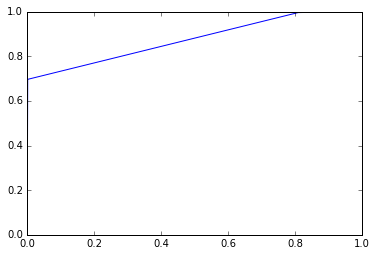

In [23]:
# Previously created the 'position_level' column which notes whether the job is a 'senior', 'manager', or 'other' level
# job title.
# Prepare our training and test data.
featuresList = ['position_level']
yCol = 'above_median'

# create the feature matrix
Xmatrix = patsy.dmatrix('~ C(position_level) -1', dfJobListing)

X_train, X_test, y_train, y_test = train_test_split(Xmatrix, dfJobListing[yCol], test_size=0.33, random_state=42)

# Fit and generate a model.
logit = LogisticRegression()
logit.fit(X_train,y_train)
predictions = logit.predict(X_test)

# runID, regression, featureCols, ycol, measure, result, notes
# Log results of model
runID = 1
regression = 'LOGISTIC'
logModelRun(runID,regression,featuresList,yCol,'TEST SCORE',logit.score(X_test,y_test))

# Print out analytical values for the model.
print 'LOGISTIC REGRESSION MODEL'
print 'SCIKIT-LEARN'
print 'FEATURE VARIABLES:'
print 'position_level'
print 'DEPENDANT VARIABLE:'
print 'above_median'
print 'TEST SCORE:'
print logit.score(X_test,y_test)
print 'LOG ODDS'
print '---------------'
print 'COEFFICIENTS:'
print logit.coef_
logModelRun(runID,regression,featuresList,yCol,'LOG ODDS-COEFFICIENTS',logit.coef_)
print 'Y-INTERCEPT:'
print logit.intercept_
logModelRun(runID,regression,featuresList,yCol,'LOG ODDS - Y-INTERCEPT',logit.intercept_)
print 'ODDS'
print '---------------'
print 'COEFFICIENTS:'
print np.exp(logit.coef_)
logModelRun(runID,regression,featuresList,yCol,'ODDS - COEFFICIENTS',np.exp(logit.coef_))
print 'Y-INTERCEPT:'
print np.exp(logit.intercept_)
logModelRun(runID,regression,featuresList,yCol,'ODDS - Y-INTERCEPT',np.exp(logit.intercept_))
print '---------------'
print ''
print 'PROBABILITIES:'
actuals = logit.predict(X_test) 
probas = logit.predict_proba(X_test)
logModelRun(runID,regression,featuresList,yCol,'PROBABILITIES',np.unique(probas[:,0]))
print np.unique(probas[:,0])
plt.plot(roc_curve(y_test, probas[:,1])[0], roc_curve(y_test, probas[:,1])[1])

#### Use cross-validation in scikit-learn to evaluate the model above. 
- Evaluate the accuracy, AUC, precision and recall of the model. 
- Discuss the differences and explain when you want a high-recall or a high-precision model in this scenario.

In [24]:
gs = grid_search.GridSearchCV(
    estimator=LogisticRegression(),
    param_grid={'C': [10**-i for i in range(-5, 5)], 'class_weight': [None, 'auto']},
    cv=cross_validation.KFold(n=len(Xmatrix), n_folds=10),
    scoring='roc_auc'
)

gs.fit(Xmatrix,dfJobListing[yCol])
runID = 2
regression = 'GRIDSEARCH-LOGISTIC'

/Users/tiffanydwilson/anaconda/lib/python2.7/site-packages/sklearn/utils/class_weight.py:62: DeprecationWarning: The class_weight='auto' heuristic is deprecated in 0.17 in favor of a new heuristic class_weight='balanced'. 'auto' will be removed in 0.19
  " 0.19", DeprecationWarning)
/Users/tiffanydwilson/anaconda/lib/python2.7/site-packages/sklearn/utils/class_weight.py:62: DeprecationWarning: The class_weight='auto' heuristic is deprecated in 0.17 in favor of a new heuristic class_weight='balanced'. 'auto' will be removed in 0.19
  " 0.19", DeprecationWarning)
/Users/tiffanydwilson/anaconda/lib/python2.7/site-packages/sklearn/utils/class_weight.py:62: DeprecationWarning: The class_weight='auto' heuristic is deprecated in 0.17 in favor of a new heuristic class_weight='balanced'. 'auto' will be removed in 0.19
  " 0.19", DeprecationWarning)
/Users/tiffanydwilson/anaconda/lib/python2.7/site-packages/sklearn/utils/class_weight.py:62: DeprecationWarning: The class_weight='auto' heuristic i

In [25]:
logModelRun(runID,regression,featuresList,yCol,'GRID SCORES',gs.grid_scores_)
print 'GRID SCORES:'
gs.grid_scores_

GRID SCORES:


[mean: 0.81359, std: 0.14382, params: {'C': 100000, 'class_weight': None},
 mean: 0.81359, std: 0.14382, params: {'C': 100000, 'class_weight': 'auto'},
 mean: 0.81359, std: 0.14382, params: {'C': 10000, 'class_weight': None},
 mean: 0.81359, std: 0.14382, params: {'C': 10000, 'class_weight': 'auto'},
 mean: 0.81359, std: 0.14382, params: {'C': 1000, 'class_weight': None},
 mean: 0.81359, std: 0.14382, params: {'C': 1000, 'class_weight': 'auto'},
 mean: 0.81359, std: 0.14382, params: {'C': 100, 'class_weight': None},
 mean: 0.81359, std: 0.14382, params: {'C': 100, 'class_weight': 'auto'},
 mean: 0.81359, std: 0.14382, params: {'C': 10, 'class_weight': None},
 mean: 0.81359, std: 0.14382, params: {'C': 10, 'class_weight': 'auto'},
 mean: 0.81359, std: 0.14382, params: {'C': 1, 'class_weight': None},
 mean: 0.81359, std: 0.14382, params: {'C': 1, 'class_weight': 'auto'},
 mean: 0.81359, std: 0.14382, params: {'C': 0.1, 'class_weight': None},
 mean: 0.81359, std: 0.14382, params: {'C': 0.

In [26]:
logModelRun(runID,regression,featuresList,yCol,'BEST ESTIMATOR',gs.best_estimator_)
print 'BEST ESTIMATOR:'
gs.best_estimator_

BEST ESTIMATOR:


LogisticRegression(C=100000, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

In [27]:
logModelRun(runID,regression,featuresList,yCol,'BEST PARAMS',gs.best_params_)
print 'BEST PARAMS:'
gs.best_params_

BEST PARAMS:


{'C': 100000, 'class_weight': None}

In [28]:
logModelRun(runID,regression,featuresList,yCol,'BEST SCORE',gs.best_score_)
print 'BEST SCORE (accuracy):'
print gs.best_score_

BEST SCORE (accuracy):
0.8135911368


LOGISTIC REGRESSION MODEL
SCIKIT-LEARN
FEATURE VARIABLES:
position_level
DEPENDANT VARIABLE:
above_median
TEST SCORE:
0.823640960809
LOG ODDS
---------------
COEFFICIENTS:
[[-5.23197627 -1.18033576  6.76911734]]
Y-INTERCEPT:
[ 0.35680531]
ODDS
---------------
COEFFICIENTS:
[[  5.34295574e-03   3.07175583e-01   8.70543162e+02]]
Y-INTERCEPT:
[ 1.42875767]
---------------

PROBABILITIES:
[  8.03344986e-04   6.94985244e-01   9.92424044e-01]


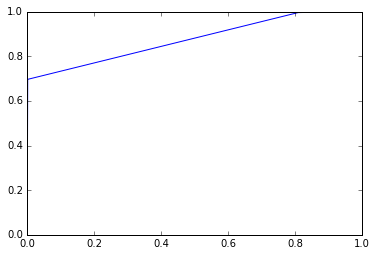

In [29]:
# Run another logistic regression model using the best parameters as determined by the grid search cross validation.
# Fit and generate a model.
logit = LogisticRegression(C=100000, class_weight= None)
logit.fit(X_train,y_train)
predictions = logit.predict(X_test)

# runID, regression, featureCols, ycol, measure, result, notes
# Log results of model
# runID = 3
regression = 'LOGISTIC'
logModelRun(runID,regression,featuresList,yCol,'TEST SCORE',logit.score(X_test,y_test))
# Print out analytical values for the model.
print 'LOGISTIC REGRESSION MODEL'
print 'SCIKIT-LEARN'
print 'FEATURE VARIABLES:'
print 'position_level'
print 'DEPENDANT VARIABLE:'
print 'above_median'
print 'TEST SCORE:'
print logit.score(X_test,y_test)
print 'LOG ODDS'
print '---------------'
print 'COEFFICIENTS:'
print logit.coef_
logModelRun(runID,regression,featuresList,yCol,'LOG ODDS-COEFFICIENTS',logit.coef_)
print 'Y-INTERCEPT:'
print logit.intercept_
logModelRun(runID,regression,featuresList,yCol,'LOG ODDS - Y-INTERCEPT',logit.intercept_)
print 'ODDS'
print '---------------'
print 'COEFFICIENTS:'
print np.exp(logit.coef_)
logModelRun(runID,regression,featuresList,yCol,'ODDS - COEFFICIENTS',np.exp(logit.coef_))
print 'Y-INTERCEPT:'
print np.exp(logit.intercept_)
logModelRun(runID,regression,featuresList,yCol,'ODDS - Y-INTERCEPT',np.exp(logit.intercept_))
print '---------------'
print ''
print 'PROBABILITIES:'
# actuals = logit.predict(X_test) 
probas = logit.predict_proba(X_test)
logModelRun(runID,regression,featuresList,yCol,'PROBABILITIES',np.unique(probas[:,0]))
print np.unique(probas[:,0])
plt.plot(roc_curve(y_test, probas[:,1])[0], roc_curve(y_test, probas[:,1])[1])

In [30]:
print 'AUC:'
auc = roc_auc_score(y_test, predictions)
print auc
logModelRun(runID,regression,featuresList,yCol,'AUC',auc)

AUC:
0.847502524358


17

In [31]:
# Print a confusion matrix
print 'CONFUSION MATRIX'
cm = confusion_matrix(y_test,predictions)
logModelRun(runID,regression,featuresList,yCol,'CONFUSION MATRIX',cm)
cm

CONFUSION MATRIX


array([[665,   1],
       [278, 638]])

In [32]:
# accuracy,  precision and recall
TP = float(cm[0,0])
FN = float(cm[0,1])
FP = float(cm[1,0])
TN = float(cm[1,1])

accuracy = (TP + TN) / (TP + FN + FP + TN)
precision = TP / (TP + FP)
recall = TP / (TP + FN)
print 'ACCURACY:  ' + str(accuracy)
print 'PRECISION:  ' + str(precision)
print 'RECALL:  ' + str(recall)
logModelRun(runID,regression,featuresList,yCol,'ACCURACY',accuracy)
logModelRun(runID,regression,featuresList,yCol,'PRECISION',precision)
logModelRun(runID,regression,featuresList,yCol,'RECALL',recall)

ACCURACY:  0.823640960809
PRECISION:  0.705196182397
RECALL:  0.998498498498


21

In [33]:
# dfModelStats = pd.DataFrame(modelRunStats,columns=['runID','regression','featureCols','ycol','measure','result','notes'])
# dfModelStats

#### Compare L1 and L2 regularization for this logistic regression model. What effect does this have on the coefficients learned?

LOGISTIC REGRESSION MODEL - L1
SCIKIT-LEARN
FEATURE VARIABLES:
position_level
DEPENDANT VARIABLE:
above_median
TEST SCORE:
0.823640960809
LOG ODDS
---------------
COEFFICIENTS:
[[-5.22866368 -1.17700186  6.77249609]]
Y-INTERCEPT:
[ 0.3534714]
ODDS
---------------
COEFFICIENTS:
[[  5.36068408e-03   3.08201385e-01   8.73489481e+02]]
Y-INTERCEPT:
[ 1.42400226]
---------------

PROBABILITIES:
[  8.03308993e-04   6.94985245e-01   9.92424205e-01]


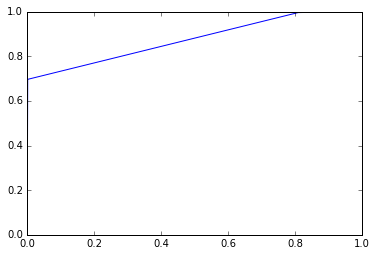

In [34]:
# Run another logistic regression model using the best parameters as determined by the grid search cross validation.
# Fit and generate a model for L1
logitL1 = LogisticRegression(C=100000, class_weight= None, penalty='l1')
logitL1.fit(X_train,y_train)
predictionsL1 = logitL1.predict(X_test)

# runID, regression, featureCols, ycol, measure, result, notes
# Log results of model
runID = 4  # L1
regression = 'LOGISTIC-L1'
logModelRun(runID,regression,featuresList,yCol,'TEST SCORE',logitL1.score(X_test,y_test),'L1')
# Print out analytical values for the model.
print 'LOGISTIC REGRESSION MODEL - L1'
print 'SCIKIT-LEARN'
print 'FEATURE VARIABLES:'
print 'position_level'
print 'DEPENDANT VARIABLE:'
print 'above_median'
print 'TEST SCORE:'
print logitL1.score(X_test,y_test)
print 'LOG ODDS'
print '---------------'
print 'COEFFICIENTS:'
print logitL1.coef_
logModelRun(runID,regression,featuresList,yCol,'LOG ODDS-COEFFICIENTS',logitL1.coef_,"L1")
print 'Y-INTERCEPT:'
print logitL1.intercept_
logModelRun(runID,regression,featuresList,yCol,'LOG ODDS - Y-INTERCEPT',logitL1.intercept_,"L1")
print 'ODDS'
print '---------------'
print 'COEFFICIENTS:'
print np.exp(logitL1.coef_)
logModelRun(runID,regression,featuresList,yCol,'ODDS - COEFFICIENTS',np.exp(logitL1.coef_),"L1")
print 'Y-INTERCEPT:'
print np.exp(logitL1.intercept_)
logModelRun(runID,regression,featuresList,yCol,'ODDS - Y-INTERCEPT',np.exp(logitL1.intercept_),"L1")
print '---------------'
print ''
print 'PROBABILITIES:' 
probasL1 = logitL1.predict_proba(X_test)
logModelRun(runID,regression,featuresList,yCol,'PROBABILITIES',np.unique(probasL1[:,0]),"L1")
print np.unique(probasL1[:,0])
plt.plot(roc_curve(y_test, probasL1[:,1])[0], roc_curve(y_test, probasL1[:,1])[1])

In [35]:
print 'AUC:'
auc = roc_auc_score(y_test, predictionsL1)
print auc
logModelRun(runID,regression,featuresList,yCol,'AUC',auc,"L1")

# Print a confusion matrix
print 'CONFUSION MATRIX'
cm = confusion_matrix(y_test,predictionsL1)
logModelRun(runID,regression,featuresList,yCol,'CONFUSION MATRIX',cm,"L1")
cm

AUC:
0.847502524358
CONFUSION MATRIX


array([[665,   1],
       [278, 638]])

In [36]:
# accuracy,  precision and recall
TP = float(cm[0,0])
FN = float(cm[0,1])
FP = float(cm[1,0])
TN = float(cm[1,1])

accuracy = (TP + TN) / (TP + FN + FP + TN)
precision = TP / (TP + FP)
recall = TP / (TP + FN)
print 'ACCURACY:  ' + str(accuracy)
print 'PRECISION:  ' + str(precision)
print 'RECALL:  ' + str(recall)
logModelRun(runID,regression,featuresList,yCol,'ACCURACY',accuracy,"L1")
logModelRun(runID,regression,featuresList,yCol,'PRECISION',precision,"L1")
logModelRun(runID,regression,featuresList,yCol,'RECALL',recall,"L1")

ACCURACY:  0.823640960809
PRECISION:  0.705196182397
RECALL:  0.998498498498


32

LOGISTIC REGRESSION MODEL - L2
SCIKIT-LEARN
FEATURE VARIABLES:
position_level
DEPENDANT VARIABLE:
above_median
TEST SCORE:
0.823640960809
LOG ODDS
---------------
COEFFICIENTS:
[[-5.23197627 -1.18033576  6.76911734]]
Y-INTERCEPT:
[ 0.35680531]
ODDS
---------------
COEFFICIENTS:
[[  5.34295574e-03   3.07175583e-01   8.70543162e+02]]
Y-INTERCEPT:
[ 1.42875767]
---------------

PROBABILITIES:
[  8.03344986e-04   6.94985244e-01   9.92424044e-01]


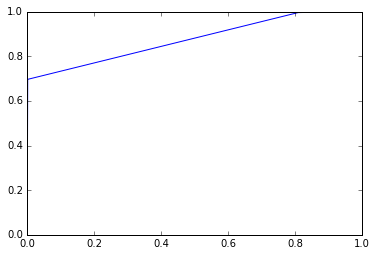

In [37]:
# Run another logistic regression model using the best parameters as determined by the grid search cross validation.
# Fit and generate a model for L2
logitL2 = LogisticRegression(C=100000, class_weight= None, penalty='l2')
logitL2.fit(X_train,y_train)
predictionsL2 = logitL2.predict(X_test)

# runID, regression, featureCols, ycol, measure, result, notes
# Log results of model
runID = 5  # L2
regression = 'LOGISTIC-L2'
logModelRun(runID,regression,featuresList,yCol,'TEST SCORE',logitL2.score(X_test,y_test),'L2')
# Print out analytical values for the model.
print 'LOGISTIC REGRESSION MODEL - L2'
print 'SCIKIT-LEARN'
print 'FEATURE VARIABLES:'
print 'position_level'
print 'DEPENDANT VARIABLE:'
print 'above_median'
print 'TEST SCORE:'
print logitL2.score(X_test,y_test)
print 'LOG ODDS'
print '---------------'
print 'COEFFICIENTS:'
print logitL2.coef_
logModelRun(runID,regression,featuresList,yCol,'LOG ODDS-COEFFICIENTS',logitL2.coef_,"L2")
print 'Y-INTERCEPT:'
print logitL2.intercept_
logModelRun(runID,regression,featuresList,yCol,'LOG ODDS - Y-INTERCEPT',logitL2.intercept_,"L2")
print 'ODDS'
print '---------------'
print 'COEFFICIENTS:'
print np.exp(logitL2.coef_)
logModelRun(runID,regression,featuresList,yCol,'ODDS - COEFFICIENTS',np.exp(logitL2.coef_),"L2")
print 'Y-INTERCEPT:'
print np.exp(logitL2.intercept_)
logModelRun(runID,regression,featuresList,yCol,'ODDS - Y-INTERCEPT',np.exp(logitL2.intercept_),"L2")
print '---------------'
print ''
print 'PROBABILITIES:' 
probasL2 = logitL2.predict_proba(X_test)
logModelRun(runID,regression,featuresList,yCol,'PROBABILITIES',np.unique(probasL2[:,0]),"L2")
print np.unique(probasL2[:,0])
plt.plot(roc_curve(y_test, probasL2[:,1])[0], roc_curve(y_test, probasL2[:,1])[1])

In [38]:
print 'AUC:'
auc = roc_auc_score(y_test, predictionsL2)
print auc
logModelRun(runID,regression,featuresList,yCol,'AUC',auc,"L2")

# Print a confusion matrix
print 'CONFUSION MATRIX'
cm = confusion_matrix(y_test,predictionsL2)
logModelRun(runID,regression,featuresList,yCol,'CONFUSION MATRIX',cm,"L2")
cm

AUC:
0.847502524358
CONFUSION MATRIX


array([[665,   1],
       [278, 638]])

In [39]:
# accuracy,  precision and recall
TP = float(cm[0,0])
FN = float(cm[0,1])
FP = float(cm[1,0])
TN = float(cm[1,1])

accuracy = (TP + TN) / (TP + FN + FP + TN)
precision = TP / (TP + FP)
recall = TP / (TP + FN)
print 'ACCURACY:  ' + str(accuracy)
print 'PRECISION:  ' + str(precision)
print 'RECALL:  ' + str(recall)
logModelRun(runID,regression,featuresList,yCol,'ACCURACY',accuracy,"L2")
logModelRun(runID,regression,featuresList,yCol,'PRECISION',precision,"L2")
logModelRun(runID,regression,featuresList,yCol,'RECALL',recall,"L2")

ACCURACY:  0.823640960809
PRECISION:  0.705196182397
RECALL:  0.998498498498


43

In [40]:
# # Uncomment if you want to review model run log.
# dfModelStats = pd.DataFrame(modelRunStats,columns=['runID','regression','featureCols','ycol','measure','result', 'notes'])
# dfModelStats

In [41]:
# Save model stats to a CSV file.
# dfModelStats.to_csv('ModelStatsLog.csv')

## Logistic Regression Model
## Coefficients (odds ratio):  
### COEFFICIENTS:
L1:  [[  5.06306930e-03   2.91090253e-01   8.24844275e+02]]
L2:  [[  5.34295574e-03   3.07175583e-01   8.70543162e+02]]

### Y-INTERCEPT:
L1:  [ 1.50770926]
L2:  [ 1.42875767]

NOTE:  Earlier when we performed a gridsearch cross validation using logistic regression, the best estimator had 
selected L2 as the penalty.



#### Continue to incorporate other text features from the title or summary that you believe will predict the salary and examine their coefficients

#### Take ~100 scraped entries with salaries. Convert them to use with your model and predict the salary - which entries have the highest predicted salaries?

In [42]:
# Use the city, position_level, and skills as features
# Predict whether the salary is above or below the median salary.
featuresList = ['city','position_level','skill_python','skill_sql','skill_machine_learning']
yCol = 'above_median'

# create the feature matrix
Xmatrix = patsy.dmatrix('~ C(city) + C(position_level) + (skill_python) + (skill_sql) + (skill_machine_learning) -1', dfJobListing)

X_train, X_test, y_train, y_test = train_test_split(Xmatrix, dfJobListing[yCol], test_size=0.33, random_state=42)

# Fit and generate a model.
logit = LogisticRegression()
logit.fit(X_train,y_train)

# Get data sample & make prediction.
dfTestSample = dfJobListing.sample(n=100,random_state=9)
Testmatrix = patsy.dmatrix('~ C(city) + C(position_level) + (skill_python) + (skill_sql) + (skill_machine_learning) -1', dfTestSample)
dfTestSample['predictions'] = logit.predict(Testmatrix)

# Show those job listings in the selected test sample that have been predcited to have a salary above the median.
dfTestSample[dfTestSample['predictions'] == 1]

,city,company,salary,summary,title,parsed_salary,salary_range,position_level,skill_python,skill_sql,skill_machine_learning,above_median,predictions
4196,Chicago,Workbridge Associates,"$170,000 a year","Big Data with Hadoop, Hive, Impala. Mid, Senio...",Director of Data Analytics,170000.0,B,senior,1,0,0,1,1
704,New York,Analytic Recruiting,"$140,000 - $160,000 a year","Statisticians, research and lead purchase of d...",Director of Predictive Analytics (Statistician),150000.0,B,senior,0,0,0,1,1
4187,Chicago,Workbridge Associates,"$110,000 - $150,000 a year",This agile team will create and develop new so...,Senior Java Computer Scientist,130000.0,B,senior,0,0,0,1,1
215,San Francisco,Workbridge Associates,"$120,000 - $155,000 a year",Industry experience working as a data scientis...,Senior Data Scientist (Healthcare),137500.0,B,senior,0,0,0,1,1
338,San Francisco,Workbridge Associates,"$120,000 - $155,000 a year",Industry experience working as a data scientis...,Senior Data Scientist (Healthcare),137500.0,B,senior,0,0,0,1,1
4165,Chicago,Workbridge Associates,"$170,000 a year","Big Data with Hadoop, Hive, Impala. Mid, Senio...",Director of Data Analytics,170000.0,B,senior,1,0,0,1,1
739,New York,Analytic Recruiting,"$140,000 - $160,000 a year","Statisticians, research and lead purchase of d...",Director of Predictive Analytics (Statistician),150000.0,B,senior,0,0,0,1,1
121,San Francisco,Workbridge Associates,"$120,000 - $155,000 a year",Industry experience working as a data scientis...,Senior Data Scientist (Healthcare),137500.0,B,senior,0,0,0,1,1
3753,Chicago,Workbridge Associates,"$170,000 a year","Big Data with Hadoop, Hive, Impala. Mid, Senio...",Director of Data Analytics,170000.0,B,senior,1,0,0,1,1
4145,Chicago,Workbridge Associates,"$170,000 a year","Big Data with Hadoop, Hive, Impala. Mid, Senio...",Director of Data Analytics,170000.0,B,senior,1,0,0,1,1


### BONUS 

#### Bonus: Use Count Vectorizer from scikit-learn to create features from the text summaries. 
- Examine using count or binary features in the model
- Re-evaluate the logistic regression model using these. Does this improve the model performance? 
- What text features are the most valuable? 

In [43]:
## YOUR CODE HERE

In [44]:
## YOUR CODE HERE

#### Re-test L1 and L2 regularization. You can use LogisticRegressionCV to find the optimal reguarlization parameters. 
- Re-test what text features are most valuable.  
- How do L1 and L2 change the coefficients?

In [45]:
## YOUR CODE HERE